In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
import random
import matplotlib.pyplot as plt
import math

In [ ]:
FullData=pd.DataFrame(columns=['stock','date','close'])
for curFile in os.listdir('HISTORICAL_DATA'):
    print("started processing {}".format(curFile))
    try:
        curData=pd.read_csv('HISTORICAL_DATA/{}'.format(curFile),sep=',')
        curData=curData[['Date','close']]
        curData.columns=['date','close']
        curData['stock']=curFile.replace('_data.csv','')
        curData.sort_values('date',inplace=True)
        prices=curData['close']
        curData['returns']=prices / prices.shift(1) - 1
        FullData=pd.concat([FullData,curData])
    except:
        print("Error with {}".format(curFile))

# Pre Processing
FullData.fillna(0,inplace=True)

# Converting to Pivot
from datetime import datetime
FullData['year']=FullData['date'].map(lambda x:  datetime.strptime(x,'%Y-%m-%d').year)
FullData['month']=FullData['date'].map(lambda x:  datetime.strptime(x,'%Y-%m-%d').month)
FullData['dateVal']=FullData['date'].map(lambda x:  datetime.strptime(x,'%Y-%m-%d'))

FullDataPivot=FullData.pivot(index='date', columns='stock', values='returns')
FullDataPivot.fillna(0,inplace=True)

# Correlation Data
corrData=FullDataPivot.corr()

In [2]:
# Get the Market MAP from the S&P 500 companies
data=pd.read_csv('/home/anantgupta/Documents/Competitions/5th/sandp500/all_stocks_5yr.csv')
dataWithReturns=pd.DataFrame(columns=['Name','date','close','return'])

# Get the return data
data=data[['Name','close','date']]
data.sort_values(['Name','close'],inplace=True)

# Function to convert to returns
for x in data['Name'].unique():
    curData=data[data['Name']==x]
    curData.sort_values('close',inplace=True)
    prices=curData['close']
    curData['return']=prices / prices.shift(1) - 1
    dataWithReturns=pd.concat([dataWithReturns,curData])
    
# Fill the data with 0 for initial returns
dataWithReturns.fillna(0,inplace=True)
dataWithReturns['year']=dataWithReturns['date'].map(lambda x : datetime.strptime(x,'%Y-%m-%d').year)
dataWithReturns['month']=dataWithReturns['date'].map(lambda x : datetime.strptime(x,'%Y-%m-%d').month)
dataWithReturns['day']=dataWithReturns['date'].map(lambda x : datetime.strptime(x,'%Y-%m-%d').day)
dataPivot=dataWithReturns.pivot(index='date',columns='Name',values='return')

/home/anantgupta/.conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/anantgupta/.conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# CAPM
monthPivot=dataWithReturns[(dataWithReturns['year']==2018) & (dataWithReturns['month']==1)].pivot(index='date',columns='Name',values='return')
monthPivot.fillna(0,inplace=True)
monthEndAndStart=monthPivot.values[[0,-1],:]
returnData=np.array([(monthEndAndStart[1][x] - monthEndAndStart[0][x])/monthEndAndStart[0][x] for x in range(505)]).reshape(505,1)
returnData=np.nan_to_num(returnData)
covMatrix=np.cov(monthPivot.values.T)

returnRiskArray=[]

#for maxValue in [0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
for maxValue in [0.05]:
    ranges=[]
    for x in range(20):
        ranges.append(np.linspace(0,maxValue,2))

    answer = [v for v in itertools.product(*ranges) if sum(v) > 0.7 and sum(v) < 0.8]
    returnData=np.array([(monthEndAndStart[1][x] - monthEndAndStart[0][x])/monthEndAndStart[0][x] for x in range(505)]).reshape(505,1)
    returnData=np.nan_to_num(returnData)
    for randomIterations in range(10):
        curStockIndex=random.sample(set(range(505)), 20)
        for w1 in answer:
            curDict={curStockIndex[x]:w1[x] for x in range(len(w1))}
            weights=np.array([curDict[x] if x in curStockIndex else 0.0 for x in range(505)]).reshape(505,1)
            covMatrix=np.cov(monthPivot.values.T)
            returnPortfolio=np.matmul(returnData.T,weights)
            devPortfolio=np.matmul(np.matmul(weights.T,covMatrix),weights)
            returnRiskArray.append([weights,returnPortfolio[0][0],np.sqrt(devPortfolio[0][0])])
            
# Plotting the CAPM line
plt.scatter([x[2] for x in returnRiskArray],[x[1] for x in returnRiskArray])
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()


# Return 0.03811738759680715, risk :  0.7474532181968696
[x[0] for x in returnRiskArray if x[1] < 0.04 and x[1] > 0.037 and x[2] > 0.5 and x[2] < 0.8 ]
optimalWeights=[x[0] for x in returnRiskArray if x[1]==0.03811738759680715 and x[2]==0.7474532181968696]
print(optimalWeights)

In [ ]:
plt.scatter([x[2] for x in returnRiskArray],[x[1] for x in returnRiskArray])
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()


[[x[1],x[2]] for x in returnRiskArray if x[1] < 0.04 and x[1] > 0.035 and x[2] > 0.4 and x[2] < 0.55 ]
optimalWeights=[x[0] for x in returnRiskArray if x[1]==0.035122917453329384 and x[2]==0.5370018533265882]
np.array(optimalWeights).reshape(1,505)[0]

0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.05, 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  

In [ ]:
# Now we will run deep portfolio to come up with the corresponding market map for the stocks and check what are the insights that we get

# 1) MARKET MAP
monthPivot=dataWithReturns.pivot(index='date',columns='Name',values='return')
monthPivot.fillna(0,inplace=True)
monthPivot.shape

In [ ]:
import tensorflow as tf
import numpy as np

class TFAutoEncoder():
    # INIT function
    def __init__(self,X,learningRate,ratio1,ratio2):
        # Input Data
        self.X=X
        
        # Input Placeholder
        self.x_input=tf.placeholder("float32",(None,X.shape[1]))
        
        # Intermediate Variables
        self.encoder_1_weight=tf.Variable(tf.random_uniform([self.X.shape[1],self.X.shape[1]/ratio1]))
        self.encoder_2_weight=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1,self.X.shape[1]/ratio2]))
        self.decoder_1_weight=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio2,self.X.shape[1]/ratio1]))
        self.decoder_2_weight=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1,self.X.shape[1]]))
        self.encoder_1_bias=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1]))
        self.encoder_2_bias=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio2]))
        self.decoder_1_bias=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1]))
        self.decoder_2_bias=tf.Variable(tf.random_uniform([self.X.shape[1]]))
                
        self.encoder_1=tf.add(tf.matmul(self.x_input,self.encoder_1_weight),self.encoder_1_bias)
        self.encoder_2=tf.nn.sigmoid(tf.add(tf.matmul(self.encoder_1,self.encoder_2_weight),self.encoder_2_bias))
        self.decoder_1=tf.nn.sigmoid(tf.add(tf.matmul(self.encoder_2,self.decoder_1_weight),self.decoder_1_bias))
        self.decoder_2=tf.add(tf.matmul(self.decoder_1,self.decoder_2_weight),self.decoder_2_bias)
        
        self.loss=tf.reduce_mean(tf.pow(self.x_input-self.decoder_2,2))
        self.optimizer=tf.train.GradientDescentOptimizer(learningRate).minimize(self.loss)
        self.init=tf.global_variables_initializer()
        
    def train(self,execRange=1000):
        with tf.Session() as sess:
            sess.run(self.init)
            for curIteration in range(execRange):
                _,curLoss,self.recreatedData=sess.run([self.optimizer,self.loss,self.decoder_2],feed_dict={self.x_input:self.X})
                if(curIteration % 1000==0):
                    print("The loss at step {} is {}".format(curIteration,curLoss))
                
if __name__=="__main__":
    # Input Data
    data=monthPivot.values
    ae=TFAutoEncoder(data,0.01,10,20)
    ae.train(50000)
    
    # We will check the recreated the matrix and check which one has the least RMSE
    rmseDict=[]
    for x in range(data.shape[1]):
        rmseDict.append([monthPivot.columns.values[x],math.sqrt(sum([(xi-yi)**2 for xi,yi in zip(data[:,x],ae.recreatedData[:,x])]))])
    
    

In [ ]:
# Stocks that explain the market a lot
NameList=pd.DataFrame(rmseDict,columns=['Name','RMSE']).sort_values('RMSE')[0:50].values[:,0]
monthPivot=dataWithReturns[(dataWithReturns['year']==2018) & (dataWithReturns['month']==1) & (dataWithReturns['Name'].isin(NameList))].pivot(index='date',columns='Name',values='close')
monthPivot.fillna(0,inplace=True)
monthEndAndStart=monthPivot.values[[0,-1],:]
returnData=np.array([(monthEndAndStart[1][x] - monthEndAndStart[0][x])/monthEndAndStart[0][x] for x in range(50)]).reshape(50,1)
returnData=np.nan_to_num(returnData)
covMatrix=np.cov(monthPivot.values.T)

returnRiskArray=[]

for maxValue in [0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
    ranges=[]
    for x in range(20):
        ranges.append(np.linspace(0,maxValue,2))

    answer = [v for v in itertools.product(*ranges) if sum(v) > 0.7 and sum(v) < 0.8]
    returnData=np.array([(monthEndAndStart[1][x] - monthEndAndStart[0][x])/monthEndAndStart[0][x] for x in range(50)]).reshape(50,1)
    returnData=np.nan_to_num(returnData)
    for randomIterations in range(10):
        curStockIndex=random.sample(set(range(50)), 20)
        for w1 in answer:
            curDict={curStockIndex[x]:w1[x] for x in range(len(w1))}
            weights=np.array([curDict[x] if x in curStockIndex else 0.0 for x in range(50)]).reshape(50,1)
            covMatrix=np.cov(monthPivot.values.T)
            returnPortfolio=np.matmul(returnData.T,weights)
            devPortfolio=np.matmul(np.matmul(weights.T,covMatrix),weights)
            returnRiskArray.append([weights,returnPortfolio[0][0],np.sqrt(devPortfolio[0][0])])
            if(len(returnRiskArray) > 1000000):
                break
        if(len(returnRiskArray) > 1000000):
            break
    if(len(returnRiskArray) > 1000000):
            break
            
# Plotting the CAPM line
plt.scatter([x[2] for x in returnRiskArray],[x[1] for x in returnRiskArray])
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()


# Return 0.03811738759680715, risk :  0.7474532181968696
#[x[0] for x in returnRiskArray if x[1] < 0.04 and x[1] > 0.037 and x[2] > 0.5 and x[2] < 0.8 ]
#optimalWeights=[x[0] for x in returnRiskArray if x[1]==0.03811738759680715 and x[2]==0.7474532181968696]
#print(optimalWeights)

In [ ]:
# Bottom 50 stocks
NameList=pd.DataFrame(rmseDict,columns=['Name','RMSE']).sort_values('RMSE')[-50:].values[:,0]
monthPivot=dataWithReturns[(dataWithReturns['year']==2018) & (dataWithReturns['month']==1) & (dataWithReturns['Name'].isin(NameList))].pivot(index='date',columns='Name',values='close')
monthPivot.fillna(0,inplace=True)
monthEndAndStart=monthPivot.values[[0,-1],:]
returnData=np.array([(monthEndAndStart[1][x] - monthEndAndStart[0][x])/monthEndAndStart[0][x] for x in range(50)]).reshape(50,1)
returnData=np.nan_to_num(returnData)
covMatrix=np.cov(monthPivot.values.T)

returnRiskArray=[]

#for maxValue in [0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
for maxValue in [0.05]:
    ranges=[]
    for x in range(20):
        ranges.append(np.linspace(0,maxValue,2))

    answer = [v for v in itertools.product(*ranges) if sum(v) > 0.7 and sum(v) < 0.8]
    returnData=np.array([(monthEndAndStart[1][x] - monthEndAndStart[0][x])/monthEndAndStart[0][x] for x in range(50)]).reshape(50,1)
    returnData=np.nan_to_num(returnData)
    for randomIterations in range(10):
        curStockIndex=random.sample(set(range(50)), 20)
        for w1 in answer:
            curDict={curStockIndex[x]:w1[x] for x in range(len(w1))}
            weights=np.array([curDict[x] if x in curStockIndex else 0.0 for x in range(50)]).reshape(50,1)
            covMatrix=np.cov(monthPivot.values.T)
            returnPortfolio=np.matmul(returnData.T,weights)
            devPortfolio=np.matmul(np.matmul(weights.T,covMatrix),weights)
            returnRiskArray.append([weights,returnPortfolio[0][0],np.sqrt(devPortfolio[0][0])])
            
# Plotting the CAPM line
plt.scatter([x[2] for x in returnRiskArray],[x[1] for x in returnRiskArray])
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()


# Return 0.03811738759680715, risk :  0.7474532181968696
#[x[0] for x in returnRiskArray if x[1] < 0.04 and x[1] > 0.037 and x[2] > 0.5 and x[2] < 0.8 ]
#optimalWeights=[x[0] for x in returnRiskArray if x[1]==0.03811738759680715 and x[2]==0.7474532181968696]
#print(optimalWeights)

In [ ]:
# 2. Create the LATENT FEATURES for each stock

import tensorflow as tf
import numpy as np

class TFAutoEncoder():
    # INIT function
    def __init__(self,X,learningRate,ratio1,ratio2):
        # Input Data
        self.X=X
        
        # Input Placeholder
        self.x_input=tf.placeholder("float32",(None,X.shape[1]))
        
        # Intermediate Variables
        self.encoder_1_weight=tf.Variable(tf.random_uniform([self.X.shape[1],self.X.shape[1]/ratio1]))
        self.encoder_2_weight=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1,self.X.shape[1]/ratio2]))
        self.decoder_1_weight=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio2,self.X.shape[1]/ratio1]))
        self.decoder_2_weight=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1,self.X.shape[1]]))
        self.encoder_1_bias=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1]))
        self.encoder_2_bias=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio2]))
        self.decoder_1_bias=tf.Variable(tf.random_uniform([self.X.shape[1]/ratio1]))
        self.decoder_2_bias=tf.Variable(tf.random_uniform([self.X.shape[1]]))
                
        self.encoder_1=tf.add(tf.matmul(self.x_input,self.encoder_1_weight),self.encoder_1_bias)
        self.encoder_2_data=tf.add(tf.matmul(self.encoder_1,self.encoder_2_weight),self.encoder_2_bias)
        self.encoder_2=tf.nn.sigmoid(tf.add(tf.matmul(self.encoder_1,self.encoder_2_weight),self.encoder_2_bias))
        self.decoder_1=tf.nn.sigmoid(tf.add(tf.matmul(self.encoder_2,self.decoder_1_weight),self.decoder_1_bias))
        self.decoder_2=tf.add(tf.matmul(self.decoder_1,self.decoder_2_weight),self.decoder_2_bias)
        
        self.loss=tf.reduce_mean(tf.pow(self.x_input-self.decoder_2,2))
        self.optimizer=tf.train.GradientDescentOptimizer(learningRate).minimize(self.loss)
        self.init=tf.global_variables_initializer()
        
    def train(self,execRange=1000):
        with tf.Session() as sess:
            sess.run(self.init)
            for curIteration in range(execRange):
                _,curLoss,self.encoderData=sess.run([self.optimizer,self.loss,self.encoder_2_data],feed_dict={self.x_input:self.X})
                if(curIteration % 1000==0):
                    print("The loss at step {} is {}".format(curIteration,curLoss))
                
if __name__=="__main__":
    # Input Data
    monthPivot=dataWithReturns.pivot(index='date',columns='Name',values='return')
    monthPivot.fillna(0,inplace=True)
    data=monthPivot.values.T
    ae=TFAutoEncoder(data,0.1,10,20)
    ae.train(50000)
    recreatedData=ae.encoderData

In [ ]:
# We will try to find out the stocks that are most related to each other


# For the NVIDIA stock, find out the stock with whih it has the max correlation
#nvidiaCorellation=monthPivot.corr()['NVDA']

# Most uncorrelated
#print(nvidiaCorellation.sort_values()[0:10])
#EXPE   -0.074563 : Expedia
#DIS    -0.062784 : Walt Disney
#SNA    -0.060869 : SNA : Heavy Duty machinery
#UHS    -0.060471 : Uniuversal HealthCare Services
#ESS    -0.060316 : Essex Property
#WU     -0.060296
#MYL    -0.055252
#WBA    -0.054852
#UDR    -0.054733
#EXR    -0.053736

# Most correlated
#print(nvidiaCorellation.sort_values())
#ETFC    0.111365
#HPE     0.138044
#HRB     0.152764
#RSG     0.155990
#WLTW    0.190318
#XEL     0.196631 : Excel Energy
#SYK     0.199469 : Stryker Medial technologies, knee plants
#CMA     0.228179 : Comerica Business Bank
#UNM     0.295471 : UNUM Insurance Company
#NVDA    1.000000

# Now we will be usin the latent features
recreatedData=ae.encoderData
latentcorr=np.corrcoef(recreatedData)
latentcorrData=pd.DataFrame(zip(monthPivot.columns,latentcorr[346]),columns=['Name','corr']).sort_values('corr')

# Low correlation
#latentcorrData.head(10)['Name'].values
#APTV : APTV Electrical systems
#DWDP : Du Pont
#VZ : Verizon
#KO : Coca Cola
#BHF : BrighHouse Annuities

# High correlation
#latentcorrData.tail(10)['Name'].values

#FB : Facebook
#AVGO : Broadcom digital semiconductors
#AMD : AMD Micro Devices
#FCX : FreePort
#NFLX : NetFlix
#NVDA

#For NVIDIA checking where does EA sports sit before and after


In [ ]:
# How to optimize the portfolio rejig

x_returns=tf.placeholder("float32",(None,100))
x_weights=tf.placeholder("float32",(None,100))



Accuracy of the network is 23.000000


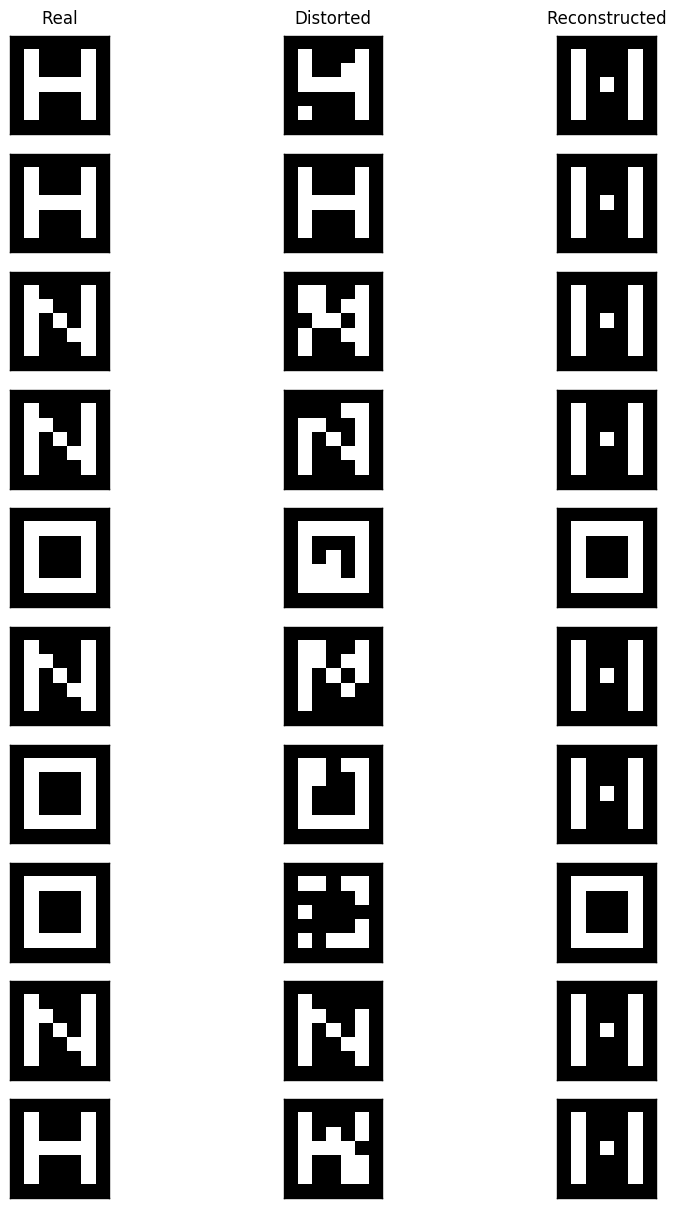

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#  Util functions


# function to plot the images after during testing phase
def plot_images(images, title, no_i_x, no_i_y=3):
    fig = plt.figure(figsize=(10, 15))
    fig.canvas.set_window_title(title)
    images = np.array(images).reshape(-1, 5, 5)
    images = np.pad(
        images, ((0, 0), (1, 1), (1, 1)), 'constant', constant_values=-1)
    for i in range(no_i_x):
        for j in range(no_i_y):
            ax = fig.add_subplot(no_i_x, no_i_y, no_i_x * j + (i + 1))
            ax.matshow(images[no_i_x * j + i], cmap="gray")
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

            if j == 0 and i == 0:
                ax.set_title("Real")
            elif j == 0 and i == 1:
                ax.set_title("Distorted")
            elif j == 0 and i == 2:
                ax.set_title("Reconstructed")


#  Dummy Data
perfect_data = {
    "P": [
        1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1,
        -1, -1, -1, -1
    ],
    "Y": [
        1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1,
        -1, -1, -1, 1, -1, -1
    ],
    "T": [
        1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1,
        -1, -1, 1, -1, -1
    ],
    "H": [
        1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1,
        -1, -1, -1, 1
    ],
    "O": [
        1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1,
        1, 1, 1, 1
    ],
    "N": [
        1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1,
        -1, -1, -1, 1
    ]
}

#  Pre-Process Data

#  Data Parameters

# Hopfield networks can hold about 0.138 \* n_neurons for better denoising <br>
# 0.138 \* n_neurons = 0.138 \* 25 = 3.45 ~ 3 <br>
n_train = 3

n_test = 100

# no of images to show in output plot
n_train_disp = 10

# Amount of distortion (0 < distort < 1)
distort = 0.1

# Size of image(width)
n_side = 5

# No of neurons
n_neurons = n_side * n_side

train_data = [np.array(d) for d in perfect_data.values()][:n_train]

# Generate test data by adding noise to train data
test_data = []
for d in range(n_test):
    r_i = np.random.randint(0, n_train)
    base_pattern = np.array(train_data[r_i])
    noise = 1 * (np.random.random(base_pattern.shape) > distort)
    np.place(noise, noise == 0, -1)
    noisy_pattern = np.multiply(base_pattern, noise)
    test_data.append((base_pattern, noisy_pattern))

# Neural Network


# Function to train the network using Hebbian learning rule
def train(neu, training_data):
    w = np.zeros([neu, neu])
    for data in training_data:
        w += np.outer(data, data)
    for diag in range(neu):
        w[diag][diag] = 0
    return w


# Function to test the network
def test(weights, testing_data):
    success = 0.0

    output_data = []

    for data in testing_data:
        true_data = data[0]
        noisy_data = data[1]
        predicted_data = retrieve_pattern(weights, noisy_data)
        if np.array_equal(true_data, predicted_data):
            success += 1.0
        output_data.append([true_data, noisy_data, predicted_data])

    return (success / len(testing_data)), output_data


# Function to retrieve individual noisy patterns
def retrieve_pattern(weights, data, steps=10):
    res = np.array(data)

    for _ in range(steps):
        for i in range(len(res)):
            raw_v = np.dot(weights[i], res)
            if raw_v > 0:
                res[i] = 1
            else:
                res[i] = -1
    return res


# Train
W = train(n_neurons, train_data)

# Test
accuracy, op_imgs = test(W, test_data)

# Print accuracy
print("Accuracy of the network is %f" % (accuracy * 100))

# Plot test result
plot_images(op_imgs, "Reconstructed Data", n_train_disp)
plt.show()